In [3]:
# Initialize Otter
import otter
grader = otter.Notebook("lab12.ipynb")

# Lab 12: Principal Component Analysis


In the lecture, we discussed how Principal Component Analysis (PCA) can be used for dimensionality reduction. Specifically, given a high dimensional dataset, PCA allows us to:
1. Understand the rank of the data. If $k$ principal components capture almost all of the variance, then the data is roughly rank $k$.
2. Create 2D scatterplots of the data. Such plots are a rank 2 representation of our data and allow us to identify clusters of similar observations visually.

In this lab, we will walk through two examples that use PCA: One involving a dataset of iris plants ([link](https://en.wikipedia.org/wiki/Iris_plant)) and another involving an artificial "surfboard" 3D dataset. You'll learn how to perform PCA using the `np.linalg` package (Part 1) and build a geometric intuition of PCA to help you understand its strengths (Part 2).


To receive credit for a lab, answer all questions correctly and submit before the deadline.

**The on-time deadline is Tuesday, November 26, 11:59 PM.** As a reminder, the slip-day policy does not apply to labs. We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline. This way, you will have ample time to contact staff for submission support.

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

**Note:** The recording was partially recorded in Spring 2022, when this lab was labeled Lab 11. In addition, questions 5 and 6 in this lab correspond to Questions 4 and 5 in the recording. There may be minor inconsistencies due to slightly different variable names (e.g. `s1` instead of `s`) but the content is the same.

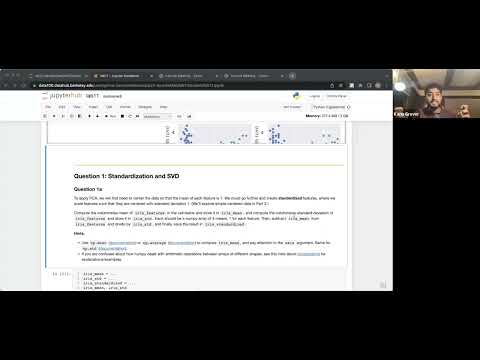

In [6]:
from IPython.display import YouTubeVideo
YouTubeVideo("gXZ9BJN6zB8", list = 'PLQCcNQgUcDfqC3hTWqqEErLjHaPq0Yk3A', listType = 'playlist')

### Collaboration Policy
Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

### Debugging Guide
If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). In this guide, you can find general questions about Jupyter notebooks / Datahub, Gradescope, common SQL errors, and more.

In [7]:
# Run this cell to set up your notebook; no further action is needed
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
%matplotlib inline

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 1: The Iris Dataset

To begin, run the following cell to load the dataset into this notebook. 
* `iris_features` will contain a `NumPy` array of 4 attributes for 150 different plants (shape $150 \times 4$). 
* `iris_target` will contain the class of each plant. There are three classes of plants in the dataset: Iris-Setosa, Iris-Versicolour, and Iris-Virginica. The class names will be stored in `iris_target_names`.
* `iris_feature_names` will be a list of 4 names, one for each attribute in `iris_features`. 

In [8]:
# Run this cell to set up; no further action is needed.

from sklearn.datasets import load_iris
iris_data = load_iris() # Loading the dataset

# Unpacking the data into arrays.
iris_features = iris_data['data']
iris_target = iris_data['target']
iris_feature_names = iris_data['feature_names']
iris_target_names = iris_data['target_names']

# Convert iris_target to string labels instead of int labels currently (0, 1, 2) for the classes.
iris_target = iris_target_names[iris_target]

Let's explore the data by creating a scatter matrix of our iris features. To do this, we'll create 2D scatter plots for every possible pair of our four features. This should result in six total scatter plots in our scatter matrix with the classes labeled in distinct colors for each plot.

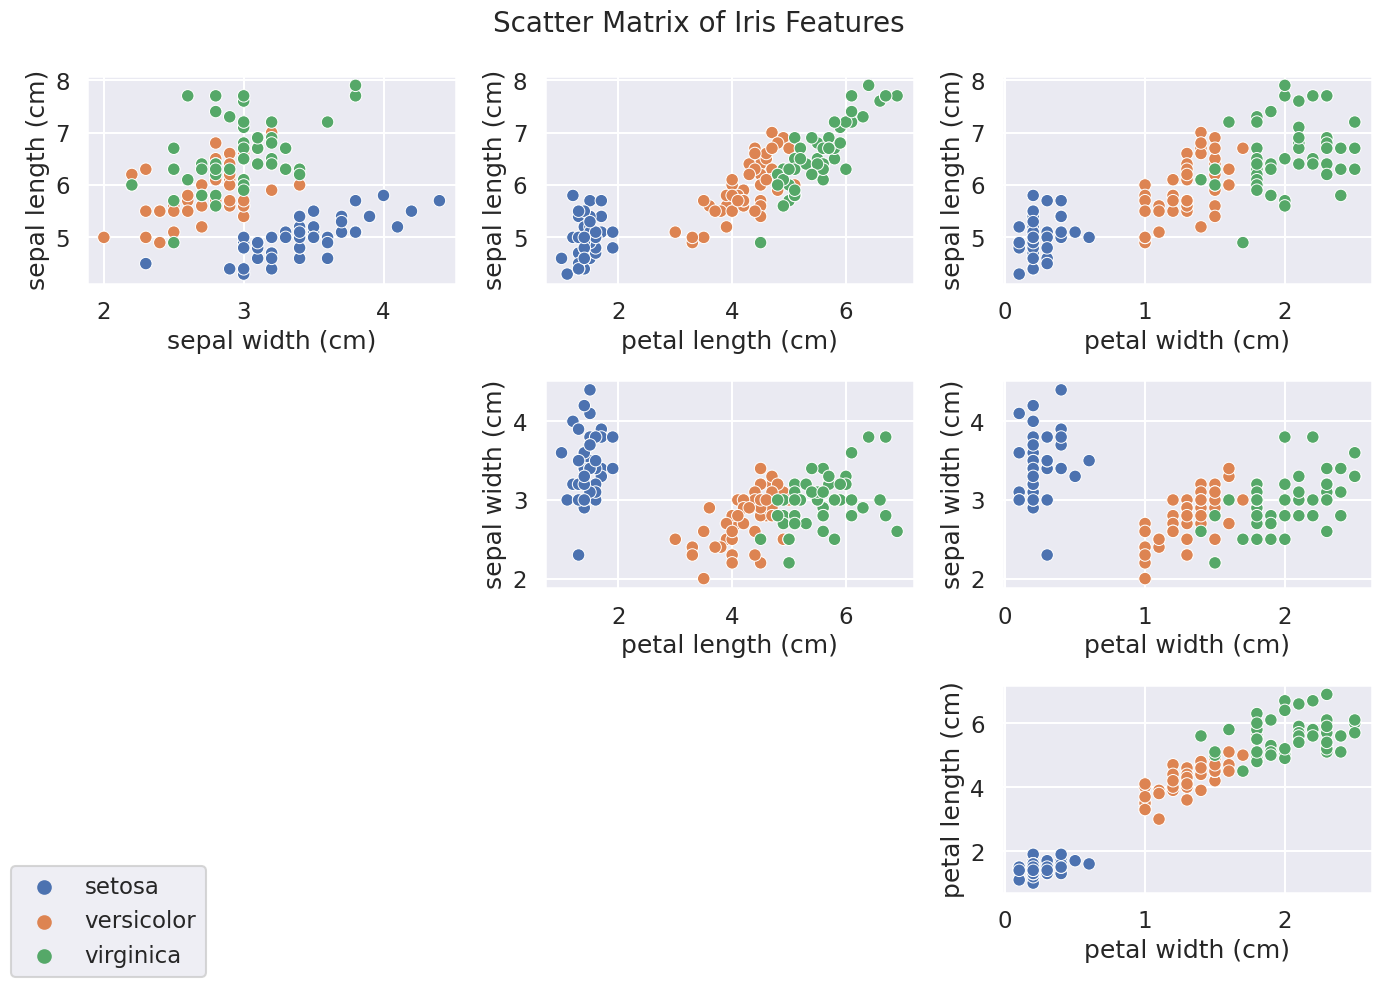

In [11]:
# Run this cell to see the plot; no further action is needed.
fig = plt.figure(figsize=(14, 10))
plt.suptitle("Scatter Matrix of Iris Features", fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i in range(1, 4):
    for j in range(i):
        plot_index = 3*j + i
        plt.subplot(3, 3, plot_index)
        sns.scatterplot(x=iris_features[:, i],
                        y=iris_features[:, j],
                        hue=iris_target,
                       legend=(plot_index == 1))
        plt.xlabel(iris_feature_names[i])
        plt.ylabel(iris_feature_names[j])
        if plot_index == 1:
            plt.legend().remove()

# same legend for all subplots.
fig.legend(loc='lower left') 
fig.tight_layout()
plt.show()

<br>

---

### Question 1a

To apply PCA, we will first need to center the data so that the mean of each feature is 0. We will also go further and create **standardized/normalized** features, where we scale features such that they are centered with a standard deviation of 1. (We'll explore simple centered data in Part 2.)

Compute the column-wise mean of `iris_features` in the cell below and store it in `iris_mean`. Then, compute the column-wise standard deviation of `iris_features` and store it in `iris_std`. Each should be a `NumPy` array of 4 means/standard deviations, 1 for each feature. 

Finally, subtract `iris_mean` from `iris_features`, divide by `iris_std`, and save the result in `iris_standardized`.

**Hints:** 
* You may find `np.mean` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)), `np.average` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.average.html)), and/or `np.std` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.std.html)) helpful. Pay attention to the `axis` argument. 
* If you are confused about how `NumPy` deals with arithmetic operations between arrays of different shapes, see this note about broadcasting [(link)](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) for explanations/examples.

In [12]:
iris_mean = np.mean(iris_features, axis = 0)
iris_std = np.std(iris_features, axis = 0)
iris_standardized = (iris_features - iris_mean) / iris_std
iris_mean, iris_std

(array([5.84333333, 3.05733333, 3.758     , 1.19933333]),
 array([0.82530129, 0.43441097, 1.75940407, 0.75969263]))

In [13]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

---

### Question 1b

As you may recall from the lecture, PCA is a specific application of the Singular Value Decomposition (SVD) for matrices. In the following cell, let's use the `np.linalg.svd` function ([documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)) to compute the SVD of our `iris_standardized` matrix. 

Store the left singular vectors $U$, singular values or diagonal elements of $\Sigma$, and (transposed) right singular vectors $V^T$ in `u`, `s`, and `vt`, respectively. Set the `full_matrices` argument of `np.linalg.svd` to `False`. Note that `s` returned by `np.linalg.svd` is a 1D array containing only the diagonal elements of $\Sigma$.

In [15]:
u, s, vt = np.linalg.svd(iris_standardized, full_matrices = False)
print(f"Dimensions of U: {u.shape}")
print(f"1D List of diagonal elements of Sigma: {s}")
print(f"Dimensions of V Transpose: {vt.shape}")

Dimensions of U: (150, 4)
1D List of diagonal elements of Sigma: [20.92306556 11.7091661   4.69185798  1.76273239]
Dimensions of V Transpose: (4, 4)


In [16]:
grader.check("q1b")

q1b results: All test cases passed!

<br/>

---

### Question 1c

What can we learn from the singular values in `s`?

To answer this question, let's take a step back and recap what we know about variance. For a given feature, say sepal length, the variance associated with it can be calculated as follows:

$$ \text{Var} (X_\text{sepal length}) = \frac{1}{n} \sum_{i=1}^n (x_{i, \text{sepal length}} - \bar{x}_\text{sepal length})^2 $$

where $x_{i, \text{sepal length}}$ refers to the sepal length of the $i$-th iris, and $\bar{x}_\text{sepal length}$ is the average sepal length across all $n$ irises.

As discussed in lecture, we define the total variance of a dataset $X$ to be the sum of variances of each of the features. In this case, 

$$ \text{Var} (X) = \text{Var} (X_\text{sepal length}) + \text{Var} (X_\text{sepal width})+ \text{Var} (X_\text{petal length}) + \text{Var} (X_\text{petal width})$$

The singular values in `s` provide us with a convenient way by which we can understand the total variance in $X$. Specifically, the total variance in the data is also equal to the sum of the squares of the singular values divided by the number of data points, that is:

$$\text{Var}(X) = \frac{\sum_{i=1}^p{\sigma_i^2}}{n} = \sum_{i=1}^p \frac{\sigma_i^2}{n} = \sum_{i=1}^p \text{Variance captured by } i\text{-th PC}$$

where for data $X$ with $n$ datapoints and $p$ features, $\sigma_i$ is the singular value corresponding to the $i$-th principal component, and $\text{Var}(X)$ is the total variance of the data. 

Compute the total variance of our data below by summing the square of each singular value in `s` and dividing the result by the total number of data points. Store the result in the variable `iris_total_variance`.

In [19]:
iris_total_variance = np.sum(s**2) / iris_standardized.shape[0]

print("iris_total_variance: {:.3f} should approximately equal the sum of the feature variances: {:.3f}"
      .format(iris_total_variance, np.sum(np.var(iris_standardized, axis=0))))

iris_total_variance: 4.000 should approximately equal the sum of the feature variances: 4.000


In [20]:
grader.check("q1c")

q1c results: All test cases passed!

As you can see, `iris_total_variance` equals the sum of the standardized feature variances.

<br/>

---

### Question 2a

Let's now use only the first two principal components to see what a 2D version of our iris data looks like.

First, construct the 2D version of the iris data by multiplying our `iris_standardized` array with the first two right singular vectors in $V$. Because the first two right singular vectors are directions for the first two principal components, this will project the iris data down from a 4D subspace to a 2D subspace.

**Hints:**
* To matrix-multiply two `NumPy` arrays, use `@` or `np.dot`. In case you're interested, the matmul documentation [(link)](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) contrasts the two methods.
* Note that in Question 1b, you computed `vt` (SVD decomposition is $U\Sigma V^T$). The first two right singular vectors in $V$ will be the two rows of `vt`, transposed [(documentation)](https://numpy.org/devdocs/reference/generated/numpy.ndarray.T.html#numpy.ndarray.T) to be column vectors instead of row vectors. 
* Since we want to obtain a 2D version of our iris dataset, the shape of `iris_2d` should be $150 \times 2$.

In [21]:
iris_2d = iris_standardized @ vt[0:2, :].T
iris_2d.shape

(150, 2)

In [22]:
grader.check("q2a")

q2a results: All test cases passed!

<br/>

Now, run the cell below to create the scatter plot of our 2D version of the iris data, `iris_2d`.

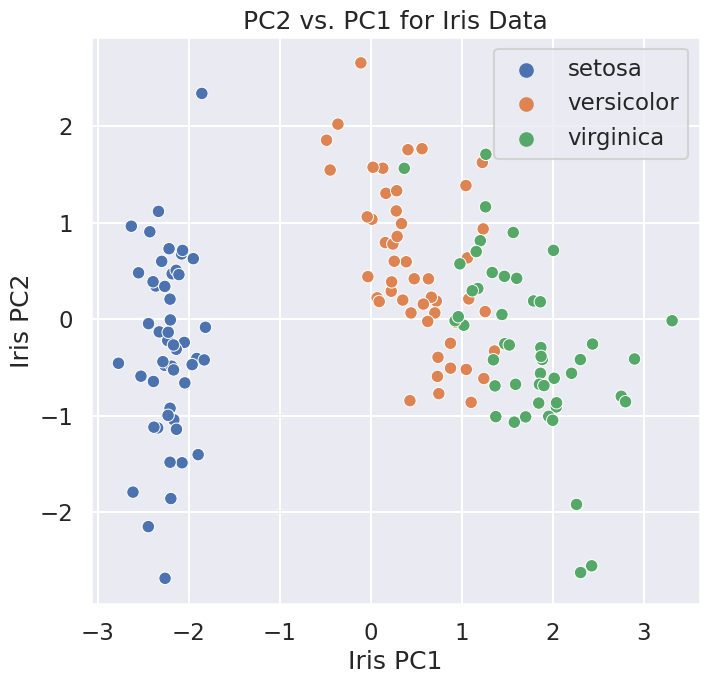

In [23]:
# Run this cell to see the plot; no further action is needed.
plt.figure(figsize = (7, 7))
plt.title("PC2 vs. PC1 for Iris Data")
plt.xlabel("Iris PC1")
plt.ylabel("Iris PC2")
sns.scatterplot(x = iris_2d[:, 0], y = iris_2d[:, 1], hue = iris_target);

<!-- BEGIN QUESTION -->

<br/>

---

### Question 2b

What do you observe about the plot above? If you were given a point in the subspace defined by PC1 and PC2, how well would you be able to classify the point as one of the three Iris types?

One thing we observe is the setosa class is very much to the left of this visualization, meaning it has very small PC1 scores. The virginica and versicolor are harder to distinguish but they have larger PC1 score than the setosa.

<!-- END QUESTION -->

<br/>

---
### Question 2c

What proportion of the total variance is accounted for when we project the iris data into two dimensions? Compute this quantity in the cell below by dividing the variance captured by the first two singular values (also known as component scores) in `s` by the `iris_total_variance` you calculated previously. Store the result in `iris_2d_variance`.

In [24]:
iris_2d_variance = np.sum(s[:2]**2) / iris_standardized.shape[0] / iris_total_variance
iris_2d_variance

0.9581320720000164

In [25]:
grader.check("q2c")

q2c results: All test cases passed!

Most of the variance in the data is explained by the two-dimensional projection!

<br/>

---

### Question 3

Next, we will create a **scree plot** ([link](https://en.wikipedia.org/wiki/Scree_plot)) to visualize the weight of each principal component. In the cell below, create a scree plot by making a line plot of the component scores (variance captured by each principal component) vs. the principal component number (1st, 2nd, 3rd, or 4th). Your graph should look similar to the image below:

**Hint:** Be sure to label your axes appropriately! You may find `plt.xticks()` ([documentation](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.xticks.html)) helpful for formatting.

<img src="images/scree.png" width="400px" />

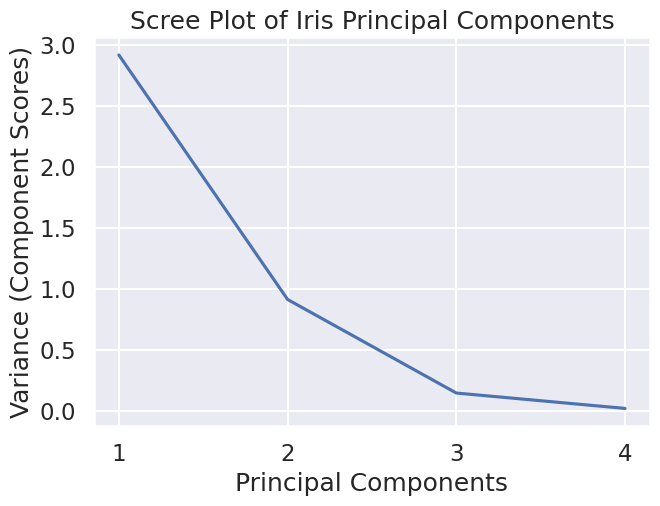

In [27]:
plt.xticks([1, 2, 3, 4])
plt.xlabel("Principal Components")
plt.ylabel("Variance (Component Scores)")
plt.title("Scree Plot of Iris Principal Components")
plt.plot([1, 2, 3, 4], np.square(s) / iris_standardized.shape[0])

<br/>

---

## [Tutorial] Biplots

Finally, we will analyze the **biplot** ([link](https://en.wikipedia.org/wiki/Biplot)) to understand how each feature contributes to the first two principal components. We do this by plotting the **directions**, or rows of $V^T$, which indicate how a feature correlates with each respective principal component. 

Recall that the columns of $U\Sigma$ are the principal components of $X$. Because $V^T$ is an orthonormal matrix:

\begin{eqnarray}
X &=& U\Sigma V^T \\
XV &=& U\Sigma V^T V = U\Sigma I\\
XV &=& U\Sigma
\end{eqnarray}


The direction vector $\vec{v}_1$ indicates the amount with which to scale each feature vector to construct the first principal component. For example, if we define the principal component as $(U\Sigma)_1 = \sigma_1\vec{u}_1$ and $\vec{v}_j$ as the $j$-th direction (and therefore the $j$-th row of $V^T$):

$$\begin{bmatrix}
| & & | \\
\vec{x}_1 & \cdots & \vec{x}_d \\
| & & | \\
\end{bmatrix} \begin{bmatrix}
| & | & \\
\vec{v}_1 & \vec{v}_2 & \cdots \\
| & | & \\
\end{bmatrix} =
\begin{bmatrix}
| & \\
\sigma_1\vec{u}_1 & \cdots  \\
| & \\
\end{bmatrix}
$$

**Note:** SVD decomposition is not unique. For example,  
\begin{eqnarray}
X &=& U\Sigma V^T \\
&=& (-U) \Sigma (-V)^T \\
&=& \tilde{U} \Sigma \tilde{U}^T \\
& \tilde{U} = -U, 
& \tilde{U} = -V
\end{eqnarray}

Here, $X = \tilde{U} \Sigma \tilde{V}^T$ is another valid SVD decomposition, and $\tilde{U} \Sigma$ is another valid principal component of X. The singular vectors $\tilde{U}$ have the opposite sign than $U$. We set the random seed here to ensure we can reproduce the same decomposition. 


Run the below cell to generate the biplot for the Iris dataset. Based on the principal components plotted in the above biplot, what can you say about how each feature contributes to PC1 and PC2?

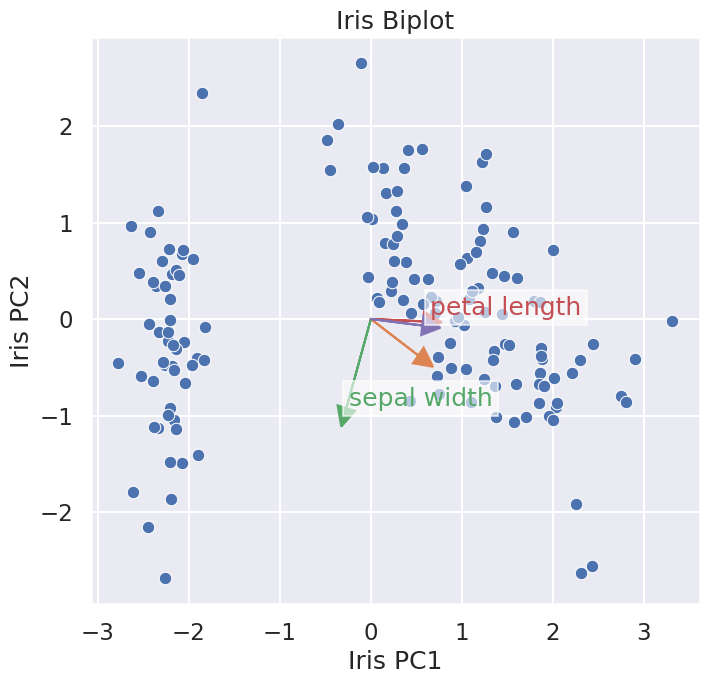

In [28]:
# Run this cell to plot a biplot; no further action is needed.
import random
random.seed(42)
cp = sns.color_palette()[1:] # Skip blue

plt.figure(figsize = (7, 7))

# First plot each datapoint in terms of the first two principal components.
sns.scatterplot(x = iris_2d[:, 0], y = iris_2d[:, 1]);

# Next, plot the loadings for PC1 and PC2.
dir1, dir2 = vt[0,:], vt[1,:]
# Just plotting the 2 arrows corresponding to 'sepal_width' and 'petal_length' 
for i, feature in enumerate(['', 'sepal width', 'petal length', '']):
    plt.arrow(0, 0,
              dir1[i], dir2[i],
              head_width=0.2, head_length=0.2, color=cp[i])
    plt.text(dir1[i] * 1+0.1*random.random(), # jitter
             dir2[i] * 1+0.1*random.random(), 
             feature, fontsize=18, color=cp[i],
             backgroundcolor=(1,1,1,0.6))

plt.title("Iris Biplot")
plt.xlabel("Iris PC1")
plt.ylabel("Iris PC2")
plt.show()

<br>

---

## Question 4

Based on the principal components plotted in the above biplot, fill in the blanks for each of the following statements:

Q4a. `sepal width` looks to be ___________ with PC1.<br/>
Q4b. `sepal width` looks to be ___________ with PC2.<br/>
Q4c. `petal length` looks to be ___________ with PC1.<br/>
Q4d. `petal length` looks to be ___________ with PC2.

Note that we have displayed the arrows for all the features in the dataset, though you only need to look at the labeled arrows to answer the question (green - sepal width, red - petal length).

You should assign each variable (e.g., `q4a`) to`'A'`, `'B'`, `'C'` corresponding to the below:

A. positively correlated<br/>
B. negatively correlated <br/>
C. uncorrelated

In some cases, it may be difficult to draw the line between positively/negatively correlated and uncorrelated. The autograder tests will accept all reasonable answers if it is ambiguous.

**Note:** This question is not included in the lab walkthrough

In [ ]:
q4a = ...
q4b = ...
q4c = ...
q4d = ...

In [ ]:
grader.check("q4")

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 2: PCA on 3D Data

**In Part 2, our goal is to see visually how PCA is simply the process of rotating the coordinate axes of our data.**

The code below reads in a 3D dataset. We named the `DataFrame` `surfboard` because the data resembles a surfboard when plotted in 3D space.

In [29]:
# Run this cell to see the plot; no further action is needed.
surfboard = pd.read_csv("data/data3d.csv")
surfboard.head(5)

,x,y,z
0,0.005605,2.298191,1.746604
1,-1.093255,2.457522,0.170309
2,0.060946,0.473669,-0.003543
3,-1.761945,2.151108,3.132426
4,1.950637,-0.194469,-2.101949


### [Tutorial] Visualize the Data

The cell below will allow you to view the data as a 3D scatterplot. Rotate the data around and zoom in and out using your trackpad or the controls at the top right of the figure.

You should see that the data is an ellipsoid that looks roughly like a surfboard or a hashbrown patty ([link](https://www.google.com/search?q=hashbrown+patty&source=lnms&tbm=isch)). It is pretty long in one direction, pretty wide in another, and relatively thin along its third dimension. We can think of these as the "length", "width", and "thickness" of the surfboard data.

Observe that the surfboard is not aligned with the x/y/z axes.

If you get an error that your browser does not support webgl, you may need to restart your kernel and/or browser.

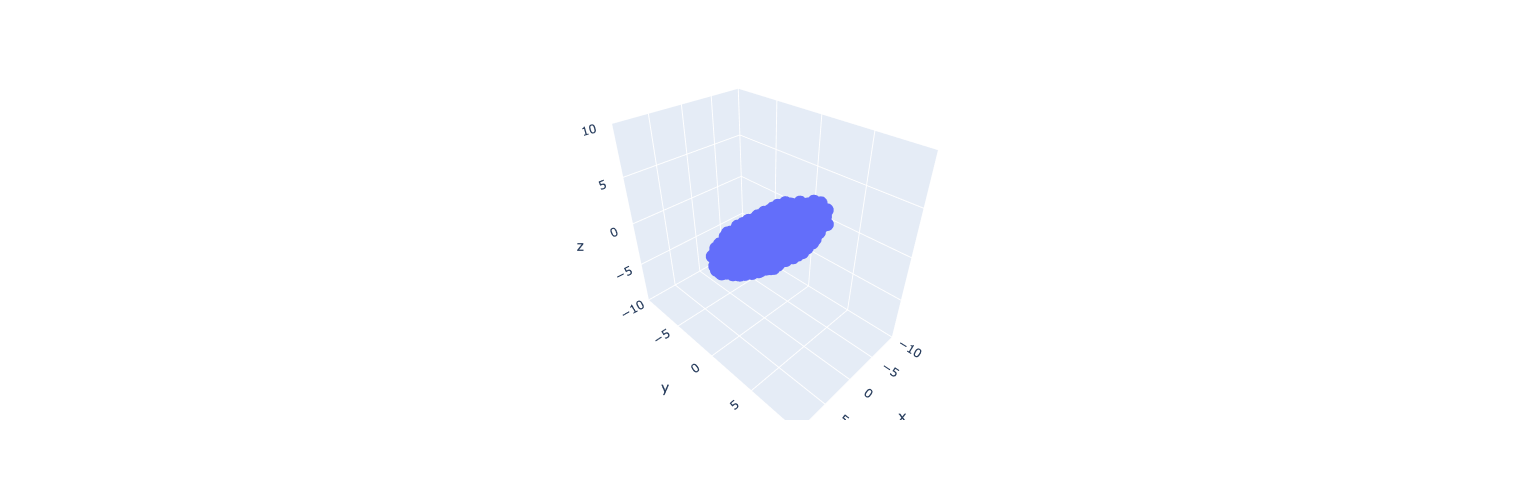

In [31]:
# Run this cell to see the plot; no further action is needed.
fig = px.scatter_3d(surfboard, 
                    x='x', y='y', z='z', 
                    range_x = [-10, 10], range_y = [-10, 10], range_z = [-10, 10], height = 500, width = 600)
fig.show()

**Visualize the Data (Colorized)**

To give the figure a little more visual pop, the following cell does the same plot but assigns a pre-determined color value (that we've arbitrarily chosen) to each point. *These colors do not mean anything important*; they're simply there as a visual aid.

You might find using the `colorize_surfboard_data` method useful later in this lab.

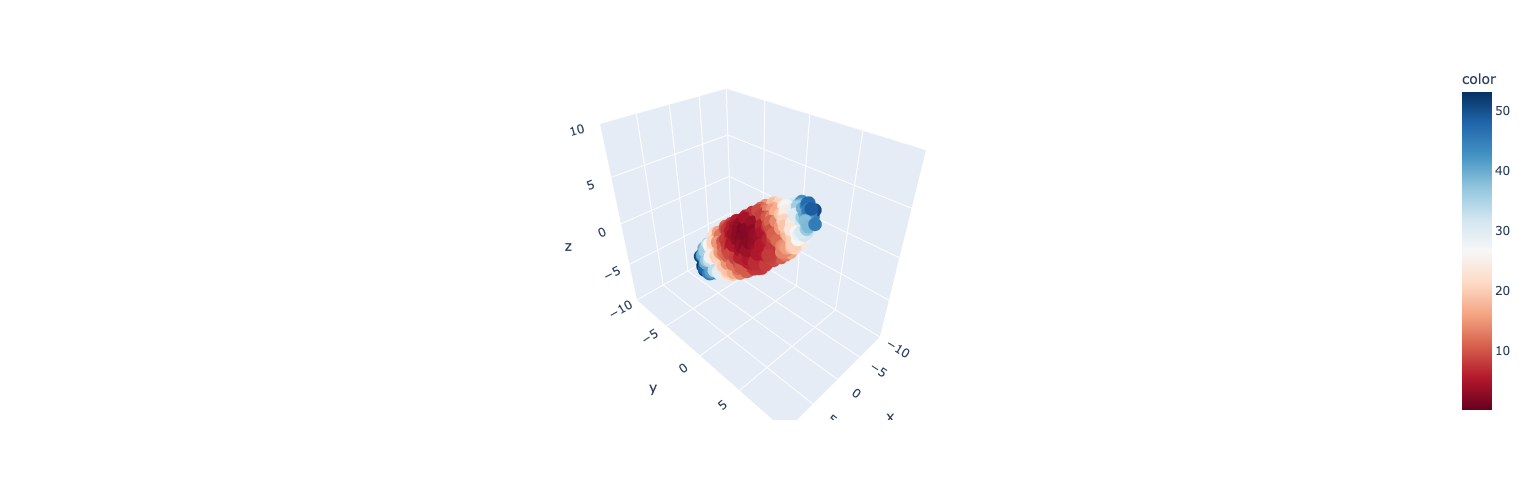

In [32]:
# Run this cell to see the colorized version of the previous cell; no further action is needed.
def colorize_surfboard_data(df):
    colors = pd.read_csv("data/surfboard_colors.csv", header = None).values
    df_copy = df.copy()
    df_copy.insert(loc = 3, column = "color", value = colors)
    return df_copy
    
fig = px.scatter_3d(colorize_surfboard_data(surfboard), 
                    x='x', y='y', z='z', 
                    range_x = [-10, 10], range_y = [-10, 10], range_z = [-10, 10], 
                    color = "color", color_continuous_scale = 'RdBu', height = 500, width = 600)
fig.show()

---

### Question 5a

In Part 1, we standardized the Iris data before performing SVD, i.e., we made features zero-mean and unit-variance. In this part, we'll try just **centering** our data so that each feature is zero-mean and variance is unchanged.

Compute the column-wise mean of `surfboard` in the cell below and store the result in `surfboard_mean`. You can make `surfboard_mean` a `NumPy` array or a `Series`, whichever is more convenient. Regardless of your data type, `surfboard_mean` should have 3 means: 1 for each attribute, with the $x$ coordinate first, then $y$, then $z$.

Then, subtract `surfboard_mean` from `surfboard`, and save the result in `surfboard_centered`. The order of the columns in `surfboard_centered` should be $x$, then $y$, then $z$.

In [33]:
surfboard_mean = np.mean(surfboard, axis = 0)
surfboard_centered = surfboard - surfboard_mean

In [34]:
grader.check("q5a")

q5a results: All test cases passed!

<br/>

---

### Question 5b

In the following cell, compute the SVD of `surfboard_centered` as $U\Sigma V^T$, and store the left singular vectors $U$, singular values / diagonal elements of $\Sigma$, and (transposed) right singular vectors $V^T$ in `u2`, `s2`, and `vt2`, respectively.

Your code should be very similar to Question 1b.

In [35]:
u2, s2, vt2 = np.linalg.svd(surfboard_centered, full_matrices = False)
u2, s2, vt2

(array([[-0.02551985, -0.02108339, -0.03408865],
        [-0.02103979, -0.0259219 ,  0.05432967],
        [-0.00283413, -0.00809889,  0.00204459],
        ...,
        [ 0.01536972, -0.00483066,  0.05673824],
        [-0.00917593,  0.0345672 ,  0.03491181],
        [-0.01701236,  0.02743128, -0.01966704]]),
 array([103.76854043,  40.38357469,  21.04757518]),
 array([[ 0.38544534, -0.67267377, -0.63161847],
        [-0.5457216 , -0.7181477 ,  0.43180066],
        [-0.74405633,  0.17825229, -0.64389929]]))

In [36]:
grader.check("q5b")

q5b results: All test cases passed!

<br/>

---
### Question 5c: Total Variance

In Question 1c, we considered standardized features (each with unit variance), whose total variance was simply the count of features. Now, we'll show that the same relationship holds between singular values `s` and the variance of our (unstandardized) data.

In the cell below, compute the total variance as the sum of the squares of the singular values $\sigma_i$ divided by the number of datapoints $n$. Here's that formula again from Question 1c:

$$\text{Var}(X) = \frac{\sum_{i=1}^p{\sigma_i^2}}{n} = \sum_{i=1}^p \frac{\sigma_i^2}{n}$$

In [37]:
total_variance_computed_from_singular_values = np.sum(s2**2) / surfboard_centered.shape[0]
total_variance_computed_from_singular_values

12.841743509780104

In [38]:
grader.check("q5c")

q5c results: All test cases passed!

<br/>

Your `total_variance_computed_from_singular_values` result should be very close to the total variance of the original `surfboard` data:

In [39]:
# Run this cell to check the result; no further action is needed.
np.var(surfboard, axis=0)

x    2.330704
y    5.727527
z    4.783513
dtype: float64

The total variance of our dataset is given by the sum of these numbers.

In [40]:
# Run this cell to check the result; no further action is needed.
total_variance_computed_from_surfboard = sum(np.var(surfboard, axis=0))
total_variance_computed_from_surfboard

12.841743509780109

Note: The variances are the same for both `surfboard_centered` and `surfboard` (why?), so we show only one to avoid redundancy.

<br/>

---

### Question 5d: Variance Explained by First Principal Component

In the cell below, set `variance_explained_by_1st_pc` to the proportion of the total variance explained by the 1st principal component. Your answer should be a number between 0 and 1.

In [41]:
variance_explained_by_1st_pc = np.sum(s2[0:1]**2) / surfboard_centered.shape[0] / total_variance_computed_from_surfboard
variance_explained_by_1st_pc

0.8385084140449129

In [42]:
grader.check("q5d")

q5d results: All test cases passed!

<br/>

We can also create a scree plot that shows the proportion of variance explained by all of our principal components, ordered from most to least. You already constructed a scree plot for the Iris data, so we'll leave the surfboard scree plot for you to do on your own time.

Instead, let's try to visualize why PCA is simply a rotation of the coordinate axes (i.e., features) of our data.

<br/>

---

## Question 6: V as a Rotation Matrix

In the lecture, we saw that the first column of $XV$ contained the first principal component values for each observation, the second column of $XV$ contained the second principal component values for each observation, and so forth.

Let's name this matrix: $P = XV = U\Sigma$ is sometimes known as the "principal component matrix".

Compute the $P$ matrix for the surfboard dataset and store it in the variable `surfboard_pcs`.

**Hint:** What does $X$ represent here: `surfboard` or `surfboard_centered`? Why?

In [43]:
surfboard_pcs = surfboard_centered @vt2.T

In [44]:
grader.check("q6")

q6 results: All test cases passed!

<br>

---

### [Tutorial] Visualizing the Principal Component Matrix

We can think of $P$ as an output of the PCA procedure. $P$ is a **rotation** of the data such that the data will now appear "axis aligned". Specifically, for a 3d dataset, if we plot PC1, PC2, and PC3 along the $x$, $y$, and $z$ axes of our plot, then the greatest amount of variation happens along the $x$-axis, the second greatest amount along the $y$-axis, and the smallest amount along the $z$-axis. 

To visualize this, run the cell below, showing our data projected onto the principal component space. Compare it with your original figure, and observe that the data is precisely the same—only it is now rotated.

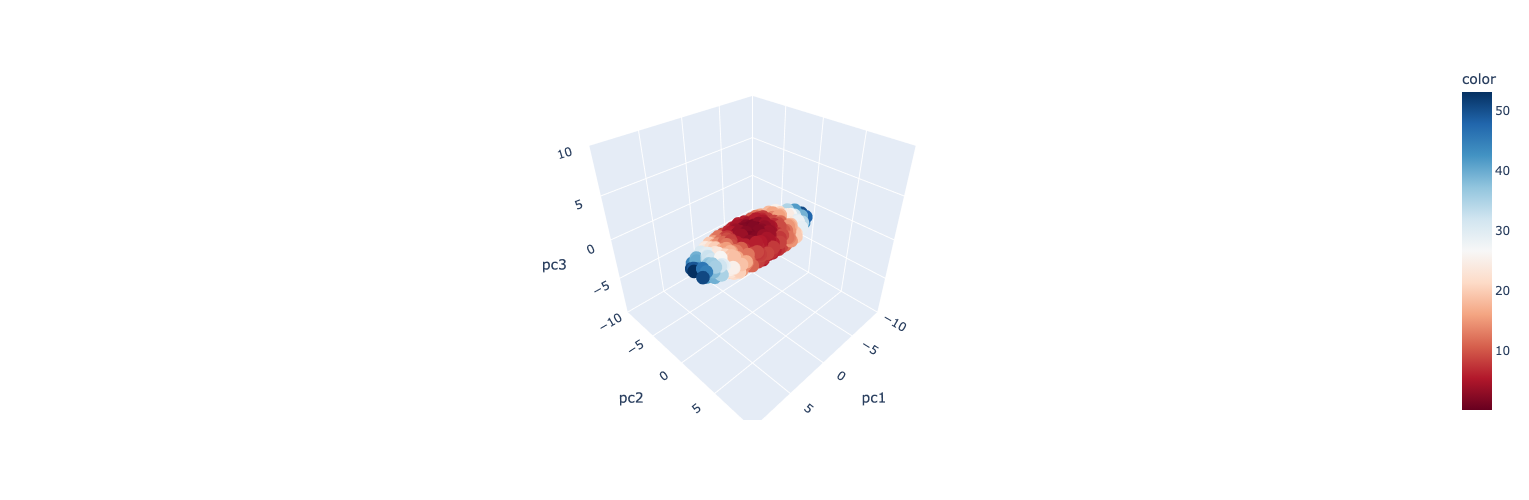

In [47]:
# Run this cell to see the plot; no further action is needed.
surfboard_pcs = surfboard_pcs.rename(columns = {0: "pc1", 1: "pc2", 2: "pc3"})
fig = px.scatter_3d(colorize_surfboard_data(surfboard_pcs), 
                    x='pc1', y='pc2', z='pc3', 
                    range_x = [-10, 10], range_y = [-10, 10], range_z = [-10, 10], 
                    color = 'color', color_continuous_scale = 'RdBu', height = 500, width = 600);
fig.show();

We can also create a 2D scatter plot of our `surfboard` data. Note that the resulting is just the 3D plot as viewed from directly "overhead".

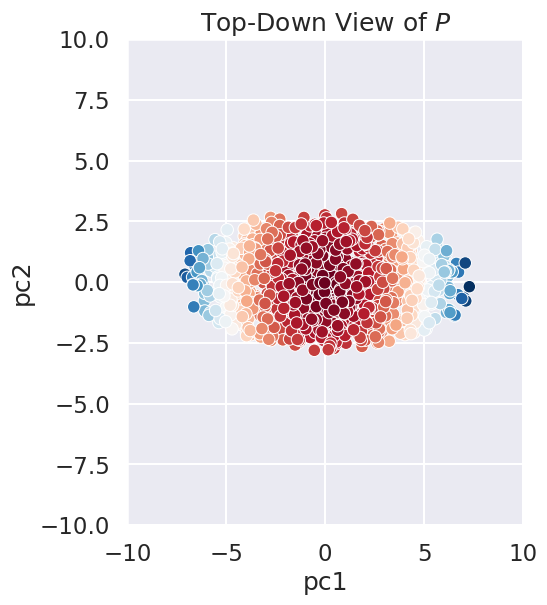

In [48]:
# Run this cell to see the plot; no further action is needed.
fig = plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

sns.scatterplot(data = colorize_surfboard_data(surfboard_pcs), 
                x = 'pc1', y = 'pc2', hue = "color", palette = "RdBu", legend = False)
plt.xlim(-10, 10);
plt.ylim(-10, 10);
plt.title("Top-Down View of $P$")
plt.show()

### Part 2 Summary

Above, we saw that the principal component matrix $P$ is simply the original data rotated in space so that it appears axis-aligned.

Whenever we create a 2D scatter plot of only the first 2 columns of $P$, we are simply looking at the data from "above", i.e., so that the 3rd (or higher) PC is invisible to us.

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Congratulations! You are finished with Lab 12!

<img src='images/bunny.PNG' width="350px" />

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly, weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://docs.google.com/forms/d/1dvvrkvDPlCHzyGjigg9U5UODHB7njceowiigNn6LWe4/viewform). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Submit this file to the Lab 12 assignment on Gradescope. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)